In [5]:
import sys, os
old_stdout = sys.stdout 
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore
def enablePrint():
    sys.stdout = old_stdout


In [6]:
import numpy as np
from cvxopt import solvers, matrix
def obstacleqp(psi, m, f, a = 0, b = 0):
  h = 1/(m+1)
  Uk = np.zeros((m,1))
  A = np.zeros((m+1,m))
  A[0,0] = 1.0
  A[m, m-1] = -1.0
  for i in range(1, m):
    A[i, i - 1] = -1.0
    A[i, i] = 1.0
  print(A)
  X1 = np.linspace(-1.0,1.0,m + 2)
  X = np.zeros((m+2,1))
  for i in range(m+2):
        X[i] = X1[i]
  F = f(X)[1:m+1]
  P = psi(X)[1:m+1]
  for i in range(0,m):
    Uk[i] = max(psi(-1.0 + 2*i/(m+1)),0.0)
  A = A/(h**2)
  gradxk = np.zeros(m)
  sol = solvers.qp(matrix(np.dot(np.transpose(A),A)),matrix(F),matrix(-np.identity(m)),matrix(-P),initvals=matrix(Uk));
  U = sol['x']
  py.plot(X,[0] + list(U) + [0])
  py.plot(X,[psi(-1)] + list(P) + [psi(1)])
  py.ylim(0,1.1)
  return X, U
f1 = lambda x: (1/x**6)
f2 = lambda x: x*0
psi = lambda x: np.sin(x)
#[X1,U1] = obstacle(psi,1000,f1,-1,1)
#[X2,U2] = obstacle(psi,1000,f2,-1,1)
#print(abs(max(U1- U2)))

In [7]:
import matplotlib.pyplot as py
%matplotlib inline


[[  0.00000000e+00]
 [  4.27492366e-03]
 [  2.13347890e-03]
 ..., 
 [  8.53165243e-06]
 [  8.53165243e-06]
 [  0.00000000e+00]]


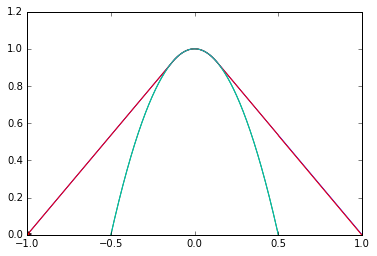

In [11]:
import numpy as np
from cvxopt import solvers, matrix
def omegabuild(Uk, P):
    m = len(Uk)
    domega = []
    omega = []
    R = []
    if Uk[0] == P[0]:
        equals = False
    else:
        equals = True
    for i in range(1,m):
        if abs(Uk[i] - P[i]) < 10**-15 and equals == False:
            domega.append(i)
            equals = True
        elif abs(Uk[i] - P[i]) >= 10**-15 and equals == True:
            domega.append(i)
            equals = False
    for j in range(len(domega)):
        if abs(Uk[domega[j]] - P[domega[j]]) == 0:
            omega = omega + [i for i in range(domega[j],domega[min(j+1,len(domega) - 1)] + 1)]
        else:
            R = R + [i for i in range(domega[j] + 1,domega[min(j+1,len(domega) - 1)])]
    domega = domega + [m-1]
    domega = sorted(list(set(domega)))
    return omega, domega, R
    
                
        
def obstacle(psi, m, a = 0, b = 0):
  h = 2/(m+1)
  Uk = np.zeros((m+2,1))
  X = np.linspace(-1.0,1.0,m + 2)
  P = psi(X)
  for i in range(1,m+1):
    Uk[i] = max(P[i],0.0)
  solved = False
  k = 0
  uold = Uk
  while (solved == False):
      k += 1
      [omega, domega, R] = omegabuild(Uk, P)
      '''
      if abs(Uk[i + 1] - P[i+1]) < 10**-9:
            if abs(Uk[i] - Uk[i - 1] - P[i + 1] + P[i]) > 10**-9:
                    Uk[i] = (Uk[i-1] + Uk[i+1])/2
            else:
                if Uk[i] < P[i]:
                    Uk[i] = P[i]
                elif abs(Uk[i + 1] - Uk[i] - P[i] + P[i - 1]) > 10**-9:
                    Uk[i] = (Uk[i - 1] + Uk[i + 1])/2
      '''
      for i in range(1,len(domega) - 1):
            j1 = domega[i]
            j2 = domega[i - 1]
            j3 = domega[i + 1]
            flag = False
            if abs(Uk[j1] - P[j1]) < 10**-15:
                if abs((Uk[j1] - Uk[j1 - 1])/h**2 + 8*(-1 + j1*h)) > 10**-8:
                    flag = True
                if flag:
                    slope = (Uk[j1] - Uk[j2])/(h*(j1 - j2))
                    for j in range(j2,j1 + 1):
                        Uk[j] = U[j-1] + slope*h
            else:
                if abs((Uk[j1] - Uk[j1 + 1])/h**2 - 8*(-1 + j1*h)) > 10**-8:
                    flag = True
                if flag:
                    slope = (Uk[j3] - Uk[j1])/(h*(j3 - j1))
                    for j in range(j1,j3):
                        Uk[j] = U[j-1] + slope*h
                  
            Uk[0] = a
            Uk[m+1] = b
            for i in range(m):
                Uk[i] = max(Uk[i],P[i])
      if  max(abs(U - uold)) < 10**-8 or k > 10000 or len(domega) == 2:
        solved = True
      uold = Uk

  '''
  while(solved == False):
     i = 0
     k += 1
     while(i < m + 2):
        found = False
        if abs(P[i] - Uk[i]) > 10**-9 and i < m + 1 and i > 0:
            found = True
            if Uk[i] > P[i]:
                if Uk[i-1] + Uk[i+1] - 2*Uk[i] != 0:
                    Uk[i] = (Uk[i+1] + Uk[i-1])/2
            else:
                Uk[i] = P[i]
        i += 1
        if abs(P[i] - Uk[i]) < 10**-9 and found == True:
            if abs(Uk[i - 1] - P[i - 1] + P[i] - Uk[i]) > 10**-9:
                Uk[i] = (Uk[i-1] + P[i+1])/2
                i = i - 1
        elif i == m+1:
            py.plot(X,list(Uk))
            py.plot(X,list(P))
            return Uk
        i += 1
     if k > 1000000 or max(abs(U-Uk)) < 10**-9:
        print(max(abs(U - Uk)))
        break
    '''
  if omega != []:
      print(abs(P[omega] - Uk[omega]))
     
  py.plot(X,list(Uk))
  py.plot(X,list(P))
  x = np.argmax(abs(U - Uk))
  i = -1 + h*x
  py.plot(i,Uk[x],'b*')
  py.plot(i,U[x],'r*')
  py.ylim(0,1.2)
  print(abs(U-Uk))
  return Uk

psi = lambda x: 1 - 4*x**2
dpsi = lambda x: -8*x
m = 1000
blockPrint()
X, U2 = obstacleqp(psi,m,f2)
enablePrint()
U = np.zeros((m+2,1))
for i in range(1,m):
    U[i] = U2[i]
U1 = obstacle(psi,m)
h = 1/(m+1)
x1 = -1 + np.sqrt(3)/2
x2 = -x1
uexact = np.zeros((m+2,1))
slope1 = (1-4*x1**2)/(x1 + 1)
slope2 = (1-4*x2**2)/(x2 - 1)
for i in range(0,m+2):
    if -1.0 + 2*i*h < x1:
        uexact[i] = slope1*2*i*h
    elif -1.0 + 2*i*h > x2:
        uexact[i] = uexact[i - 1] + 2*slope2*h
    else:
        uexact[i] = psi(-1 + 2*i*h)


In [9]:

print(max(abs(U1 - uexact)))

[ 0.00213349]


(0, 1.2)

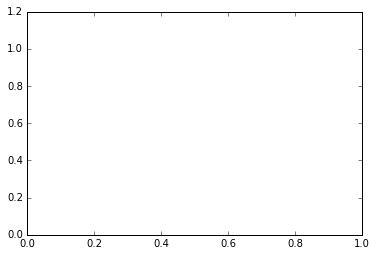

In [89]:
py.ylim(0,1.2)

In [90]:
print(uexact)

In [286]:
1/1001

0.000999000999000999

In [96]:
print(uexact- U)

(-0.1, 1.01)

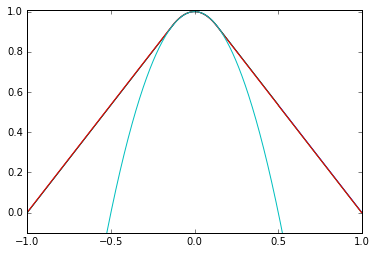

In [12]:
py.plot(X,uexact)
py.plot(X,U1)
py.plot(X,U)
py.plot(X,psi(X))
py.ylim(-.1,1.01)

In [10]:
print(uexact)

[[  0.00000000e+00]
 [  2.14145209e-03]
 [  4.28290417e-03]
 ..., 
 [  4.27799827e-03]
 [  2.13654619e-03]
 [ -4.90590027e-06]]


In [13]:
print(uexact - psi(X))

[[ 3.        ]
 [ 2.9861734 ]
 [ 2.97237874]
 ..., 
 [ 2.97237384]
 [ 2.9861685 ]
 [ 2.99999509]]
